Простые задания, по мотивам https://arxiv.org/pdf/1709.00103.pdf

In [1]:
import os
import sys

In [2]:
def add_sys_path(p):
    p = os.path.abspath(p)
    if p not in sys.path:
        sys.path.insert(0, p)

In [3]:
root = 'C://users/ddale/yandexdisk/code/NLP/seq2seq_botcamp/WikiSQL'
add_sys_path(root)

In [4]:
import sqlite3
import jsonlines

conn = sqlite3.connect("dev.db")
cursor = conn.cursor()

In [5]:
import lib
from lib.table import Table

### какие таблицы на входе

In [139]:
i = 0
id_names = {}
id2table = {}

with jsonlines.open(os.path.join(root, 'train.tables.jsonl')) as reader:
    for obj in reader:
        my_table = Table(table_id = obj["id"], header = obj['header'], types = obj['types'], rows = obj['rows'])
        id_names[obj["id"]] = my_table.name
        id2table[obj['id']] = obj
        if ('1341472' in obj["id"]):
            i = i+1
            print (obj["id"])
            print (obj['header'])
            print (obj['rows'])
            print (my_table.name)
            #print (my_table.get_schema(conn, obj["id"]))
            print()

1-1341472-11
['District', 'Incumbent', 'Party', 'First elected', 'Result', 'Candidates']
[['Florida 1', 'Joe Scarborough', 'Republican', 1994, 'Re-elected', 'Joe Scarborough (R) 72.54% Kevin Beck (D) 27.42%'], ['Florida 4', 'Tillie Fowler', 'Republican', 1992, 'Re-elected', 'Tillie Fowler (R) unopposed'], ['Florida 5', 'Karen Thurman', 'Democratic', 1992, 'Re-elected', 'Karen Thurman (D) 61.68% Dave Gentry (R) 38.32%'], ['Florida 6', 'Cliff Stearns', 'Republican', 1988, 'Re-elected', "Cliff Stearns (R) 67.18% Newell O'Brien (D) 32.82%"], ['Florida 7', 'John Mica', 'Republican', 1992, 'Re-elected', 'John Mica (R) 62.04% George Stuart (D) 37.93%'], ['Florida 8', 'Bill McCollum', 'Republican', 1980, 'Re-elected', 'Bill McCollum (R) 67.47% Al Krulick (D) 32.52%'], ['Florida 10', 'Bill Young', 'Republican', 1970, 'Re-elected', 'Bill Young (R) 66.61% Henry Green (D) 33.39%'], ['Florida 11', 'Sam Gibbons', 'Democratic', 1962, 'Retired Democratic hold', 'Jim Davis (D) 57.91% Mark Sharpe (R) 42

In [143]:
id2table['1-1341472-11']['header']

['District', 'Incumbent', 'Party', 'First elected', 'Result', 'Candidates']

### какие запросы на входе

In [7]:
from collections import Counter

In [8]:
sel_counter = Counter()
agg_counter = Counter()
cmp_counter = Counter()
cond_len_counter = Counter()
with jsonlines.open(os.path.join(root, 'train.jsonl')) as reader:
    for obj in reader:
        s = obj['sql']
        sel_counter[s['sel']] += 1
        agg_counter[s['agg']] += 1
        cond_len_counter[len(s['conds'])] += 1
        for cmp in s['conds']:
            cmp_counter[cmp[1]] += 1

In [82]:
# cond_ops = ['=', '>', '<', 'OP']
cmp_counter.most_common()

[(0, 63880), (1, 6606), (2, 6243)]

In [80]:
cond_len_counter.most_common()

[(1, 39096), (2, 13346), (3, 3019), (4, 471), (0, 423)]

In [81]:
# agg_ops = ['', 'MAX', 'MIN', 'COUNT', 'SUM', 'AVG']
agg_counter.most_common()

[(0, 40606), (3, 5114), (2, 3231), (1, 3161), (5, 2201), (4, 2042)]

#### препроцессор 

In [11]:
import youtokentome as yttm

In [12]:
train_data_path = "cheat/train_data.txt"
model_path = "cheat/example.model"

In [152]:
X_text = []
y_list = []
y_sel_list = []
y_cond_list = []
table_ids_list = []

with open(train_data_path, "w", encoding='utf-8') as fout:
    with jsonlines.open(os.path.join(root, 'train.jsonl')) as reader:
        for obj in reader:
            X_text.append(obj['question'])
            y_list.append(obj['sql']['agg'])
            y_sel_list.append(obj['sql']['sel'])
            y_cond_list.append(obj['sql']['conds'])
            table_ids_list.append(obj['table_id'])
            print(obj['question'], file=fout)

In [148]:
import random

In [161]:
i = random.randint(0, len(X_text) - 1)
print(i)
print(X_text[i])
print(y_sel_list[i])
print(id2table[table_ids_list[i]]['header'])

55077
Who is the player who was born before 1980 who currently plays for the Toronto Raptors?
0
['Player', 'Height', 'Position', 'Year born', 'Current Club']


In [51]:
X_dev_text = []
y_dev_list = []
with jsonlines.open(os.path.join(root, 'dev.jsonl')) as reader:
    for obj in reader:
        X_dev_text.append(obj['question'])
        y_dev_list.append(obj['sql']['agg'])
print(len(X_dev_text))

8421


In [83]:
yttm.BPE.train(data=train_data_path, vocab_size=30000, model=model_path)
bpe = yttm.BPE(model=model_path)

In [84]:
test_text = 'Who lives on the ocean floor?'

In [85]:
print(bpe.encode([test_text], output_type=yttm.OutputType.ID, bos=True, eos=True))
print(bpe.encode([test_text], output_type=yttm.OutputType.SUBWORD, bos=True, eos=True))

[[2, 1175, 1092, 5243, 1186, 1062, 21636, 4446, 20, 3]]
[['<BOS>', '▁Who', '▁l', 'ives', '▁on', '▁the', '▁ocean', '▁floor', '?', '<EOS>']]


In [86]:
X_token = bpe.encode(X_text, bos=True, eos=True)

In [87]:
X_dev_token = bpe.encode(X_dev_text, bos=True, eos=True)

In [166]:
for k, v in id2table.items():
    v['header_bpe'] = bpe.encode(v['header'], bos=True, eos=True)

####  предсказываем агрегацию

In [88]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class BiLSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, label_size, use_gpu, batch_size):
        super(BiLSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.use_gpu = use_gpu
        self.batch_size = batch_size
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, bidirectional=True)
        self.hidden2label = nn.Linear(hidden_dim*2, label_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # first is the hidden h
        # second is the cell c
        if self.use_gpu:
            return (Variable(torch.zeros(2, self.batch_size, self.hidden_dim).cuda()),
                    Variable(torch.zeros(2, self.batch_size, self.hidden_dim).cuda()))
        else:
            return (Variable(torch.zeros(2, self.batch_size, self.hidden_dim)),
                    Variable(torch.zeros(2, self.batch_size, self.hidden_dim)))

    def forward(self, sentence):
        x = self.embeddings(sentence).view(len(sentence), self.batch_size, -1)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y = self.hidden2label(lstm_out[-1])
        log_probs = F.log_softmax(y, dim=1)
        return log_probs

In [89]:
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
USE_GPU = False
BATCH_SIZE = 1

In [90]:
model = BiLSTMClassifier(
    embedding_dim=EMBEDDING_DIM, 
    hidden_dim=HIDDEN_DIM, 
    vocab_size=len(bpe.vocab()), 
    label_size=len(set(y_list)),
    use_gpu=USE_GPU, 
    batch_size=BATCH_SIZE
)
if USE_GPU:
    model = model.cuda()

In [100]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [92]:
from tqdm.auto import tqdm, trange

In [93]:
def get_accuracy(truth, pred):
    assert len(truth) == len(pred)
    right = 0
    for i in range(len(truth)):
        if truth[i] == pred[i]:
            right += 1.0
    return right / len(truth)


def train_epoch_progress(model, train_iter, loss_function, optimizer, text_field, label_field, epoch):
    model.train()
    avg_loss = 0.0
    truth_res = []
    pred_res = []
    count = 0
    for batch in tqdm(train_iter, desc='Train epoch '+str(epoch+1)):
        sent, label = batch.text, batch.label
        label.data.sub_(1)
        truth_res += list(label.data)
        model.batch_size = len(label.data)
        model.hidden = model.init_hidden()
        pred = model(sent)
        pred_label = pred.data.max(1)[1].numpy()
        pred_res += [x for x in pred_label]
        model.zero_grad()
        loss = loss_function(pred, label)
        avg_loss += loss.data[0]
        count += 1
        loss.backward()
        optimizer.step()
    avg_loss /= len(train_iter)
    acc = get_accuracy(truth_res, pred_res)
    return avg_loss, acc

In [94]:
#for batch in tqdm(train_iter, desc='Train epoch '+str(epoch+1)):

In [95]:
EPOCHS = 20

In [96]:
loss_function = nn.NLLLoss()

In [137]:
??torch.cosine_similarity

In [97]:
PRINT_EVERY = 300

На маленьких батчах и небольшом словарике получилось так, что лосс даже упавший вдвое с 1.5 до 0.75 приводил к тому, что всегда моделька предсказывает "ничего не агрегировать", которое встречается в 3/4 случаев.  

Увеличил словарь до 30К, уменьшил шаг с 10-3 до 10-4, поменял sgd на adam, и вроде как трейн пошёл запоминаться. 

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline

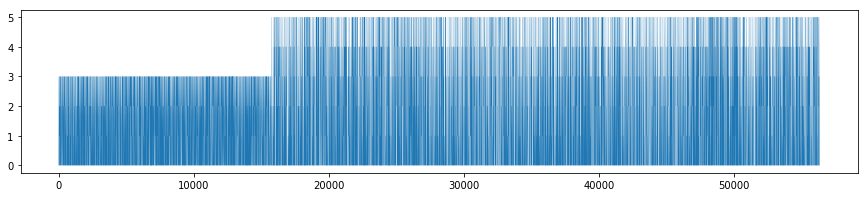

In [116]:
plt.figure(figsize=(15, 3))
plt.plot(y_list, linewidth=0.1)

array([ 5301, 25008, 35082, ..., 31689, 55540, 45803])

In [132]:
for epoch in range(EPOCHS):
    it = 0
    tot = 0
    act = 0

    for idx in tqdm(np.random.permutation(len(y_list))):
        x = torch.tensor(X_token[idx], dtype=torch.long)
        y = torch.tensor([y_list[idx]])
        
        optimizer.zero_grad()
        model.hidden = model.init_hidden()
        pred = model(x)
        l = loss_function(pred, y)
        l.backward()
        optimizer.step()
        
        it += 1
        tot += l.item()
        act += (pred.detach().numpy().argmax() == yy)
        if it == PRINT_EVERY:
            print(tot/it, act/it)
            it = 0
            tot = 0
            act = 0
    #avg_loss, acc = train_epoch_progress(model, train_iter, loss_function, optimizer, text_field, label_field, epoch)
    #tqdm.write('Train: loss %.2f acc %.1f' % (avg_loss, acc*100))

0.6969633615016937 0.81
0.7326979112625122 0.82
0.7656886800130208 0.7866666666666666
0.7166480859120686 0.7733333333333333
0.6853464021285375 0.79
0.7680416462818781 0.78
0.7307754890124003 0.7966666666666666
0.712203178803126 0.8133333333333334
0.7730471154054006 0.7833333333333333
0.781995957493782 0.7566666666666667
0.7520631104707718 0.7833333333333333
0.6507197336355846 0.78
0.6670562740166982 0.8133333333333334
0.5830300919214885 0.8333333333333334
0.6537801285584768 0.8166666666666667
0.671521024107933 0.79
0.7150744360685348 0.7633333333333333
0.6541157325108846 0.8266666666666667
0.7193737510840098 0.7433333333333333
0.6773665865262349 0.7833333333333333
0.6984126148621241 0.77
0.7149234465758005 0.72
0.6960839080810547 0.8233333333333334


KeyboardInterrupt: 

In [133]:
preds = []
for xx in tqdm(X_dev_token):
    x = torch.tensor(xx, dtype=torch.long)
    model.hidden = model.init_hidden()
    preds.append(model(x).detach().numpy().argmax())


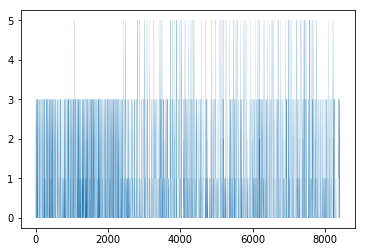

In [134]:
plt.plot(preds, linewidth=0.1);

In [135]:
import numpy as np

0.7659422871392946

In [136]:
print((np.array(preds) == np.array(y_dev_list[:len(preds)])).mean())
print((0 == np.array(y_dev_list[:len(preds)])).mean())

0.7894549340933381
0.7145232157700986


### пробуем всё

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

In [ ]:
tokenizer = WordPunctTokenizer()

def tokenize_src(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

def tokenize_tgt(x):
    return ' '.join(tokenizer.tokenize(x))

In [ ]:
def preprocess(dataset_type, datadir, source_voc_type, dist_voc_type): #создает bpe-словарики из слов в словарях sourcevoc(это все возможные слова, 
    # которые могут встретиться в вопросах на натуральном языке по этой базе данных), targetvoc(символы математического языка запроса)
    with open("{}.{}".format(dataset_type,source_voc_type), 'w') as f_src,  open("{}.{}".format(dataset_type, dist_voc_type), 'w') as f_dst:
        for line in open('{}/{}.txt'.format(datadir, dataset_type), encoding='utf-8'):
            try:
                src_line, dst_line = line.strip().split('\t')
            except:
                print (line)
                continue
            try:
                f_src.write(tokenize_src(src_line) + '\n')
                f_dst.write(tokenize_tgt(dst_line) + '\n')
            except:
                continue
                i = i +1 
                print (tokenize_src(src_line) + '\n')
                print (tokenize_tgt(dst_line) + '\n')
        
    bpe = {}
    print ("create bpe")
    for v_type in [source_voc_type, dist_voc_type]:
        learn_bpe(open('./{}.'.format(dataset_type) + v_type), open('bpe_rules.' + v_type, 'w'), num_symbols=8000)
        bpe[v_type] = BPE(open('./bpe_rules.' + v_type))
        with open('{}.bpe.'.format(dataset_type) + v_type, 'w') as f_out:
            for line in open('{}.'.format(dataset_type) + v_type):
                f_out.write(bpe[v_type].process_line(line.strip()) + '\n')

In [ ]:
preprocess('train', root + '/data', 'qw', 'qu')

#### Предсказываем агрегируемую колонку (и тип агрегации тоже, отдельной головой)

In [429]:
class ToyChooser(nn.Module):
    def __init__(self, hidden_size=64, vocab_size=14, embedding_dim=32, proj_size=128, agg_size=5):
        super().__init__()
        RNN = nn.LSTM
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.sent_rnn = RNN(embedding_dim, hidden_size, bidirectional=True)
        self.sent_proj = nn.Linear(hidden_size * 2, proj_size)
        
        self.option_rnn = RNN(embedding_dim, hidden_size, bidirectional=True) # self.sent_rnn #
        self.option_proj = nn.Linear(hidden_size * 2, proj_size)
        
        self.mix_mlp = nn.Sequential(
            nn.Linear(3 * proj_size, proj_size), 
            nn.LeakyReLU(), 
            nn.Linear(proj_size, 1),             
        )
        
        self.agg_mlp = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.LeakyReLU(), 
            nn.Linear(hidden_size, agg_size),   
        )
    
    def forward(self, sentence, options):
        batch_size = 1
        sent_len = sentence.shape[0]
        x = self.embeddings(sentence).view(sent_len, batch_size,  -1)
        sent_rnn_out, _ = self.sent_rnn(x)
        encoded_sentence = self.sent_proj(sent_rnn_out[-1])[0]
        
        dots = []
        for option in options:
            z = self.embeddings(option).view(option.shape[0], batch_size,  -1)
            opt_rnn_out, _ = self.option_rnn(z)
            encoded_option = self.option_proj(opt_rnn_out[-1])[0]
            #dots.append(torch.cosine_similarity(encoded_sentence, encoded_option, dim=0))
            dots.append(self.mix_mlp(
                torch.cat([encoded_sentence, encoded_option, torch.mul(encoded_sentence, encoded_option)])
            ))
        sel_scores = torch.stack(dots).view(1, -1)
        
        agg_scores = self.agg_mlp(sent_rnn_out[-1]).view(1, -1)
        
        return sel_scores, agg_scores

In [ ]:
class BatchedToyChooser(nn.Module):
    def __init__(self, hidden_size=64, vocab_size=14, embedding_dim=32, proj_size=128, agg_size=5):
        super().__init__()
        RNN = nn.LSTM
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.sent_rnn = RNN(embedding_dim, hidden_size, bidirectional=True)
        self.sent_proj = nn.Linear(hidden_size * 2, proj_size)
        
        self.option_rnn = RNN(embedding_dim, hidden_size, bidirectional=True) # self.sent_rnn #
        self.option_proj = nn.Linear(hidden_size * 2, proj_size)
        
        self.mix_mlp = nn.Sequential(
            nn.Linear(3 * proj_size, proj_size), 
            nn.LeakyReLU(), 
            nn.Linear(proj_size, 1),             
        )
        
        self.agg_mlp = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.LeakyReLU(), 
            nn.Linear(hidden_size, agg_size),   
        )
    
    def forward(self, sentence, options):
        batch_size = sentence.shape[1]
        #sent_len = sentence.shape[0]
        
        # pack_padded_sequence and pad_packed_sequence
        
        x = self.embeddings(sentence).view(sent_len, batch_size,  -1)
        sent_rnn_out, _ = self.sent_rnn(x)
        encoded_sentence = self.sent_proj(sent_rnn_out[-1])[0]
        
        dots = []
        for option in options:
            z = self.embeddings(option).view(option.shape[0], batch_size,  -1)
            opt_rnn_out, _ = self.option_rnn(z)
            encoded_option = self.option_proj(opt_rnn_out[-1])[0]
            #dots.append(torch.cosine_similarity(encoded_sentence, encoded_option, dim=0))
            dots.append(self.mix_mlp(
                torch.cat([encoded_sentence, encoded_option, torch.mul(encoded_sentence, encoded_option)])
            ))
        sel_scores = torch.stack(dots).view(1, -1)
        
        agg_scores = self.agg_mlp(sent_rnn_out[-1]).view(1, -1)
        
        return sel_scores, agg_scores

In [430]:
sel_model = ToyChooser(
    vocab_size=bpe.vocab_size(), 
    embedding_dim=128, 
    hidden_size=128, 
    proj_size=128,
    agg_size=len(set(y_list)),
)

In [431]:
sel_model

ToyChooser(
  (embeddings): Embedding(30000, 128)
  (sent_rnn): LSTM(128, 128, bidirectional=True)
  (sent_proj): Linear(in_features=256, out_features=128, bias=True)
  (option_rnn): LSTM(128, 128, bidirectional=True)
  (option_proj): Linear(in_features=256, out_features=128, bias=True)
  (mix_mlp): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (agg_mlp): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=6, bias=True)
  )
)

In [432]:
sel_optimizer = torch.optim.Adam(sel_model.parameters(), lr=3e-3)
sel_loss = nn.CrossEntropyLoss()
agg_loss = nn.CrossEntropyLoss()

In [433]:
PRINT_EVERY = 100
EPOCHS = 100

Моделька не факт что выигрывает, если увеличить размерность: с 32-мерными эмбеддингами она, казалось, совсем не обучалась, а с 128-тоже.

Пробуем оверфитнуться под первые 100 примеров, и вроде бы получается, хоть даже это происходит оч медленно. И даже на первой сотке лосс и акураси коррелируют не очень сильно, что вообще-то странненько. Через пару десятков эпох лосс 1e-3 начал дребезжать, но вроде потом сам выровнялся и дал таки эпохе на 20-й 98% точность. Ненадолго, правда. Надо таки его подсократить. 

Добавил вторую голову, для выбора типа агрегации. Что приятно: с двумя головами не медленнее, чем  с одной, т.к. всё равно всё время на rnn-ки уходит. Что странно: GRU учится не быстрее LSTM

После ночи обучения лосс где-то в космосе, а точность разбора безумно скачет. Чё-то я делаю не так...

In [435]:
for epoch in range(EPOCHS):
    it = 0
    tot1 = 0
    act1 = 0
    tot2 = 0
    act2 = 0

    for idx in tqdm(np.random.permutation(len(y_list))): # # 
        x = torch.tensor(X_token[idx], dtype=torch.long)
        options = [torch.tensor(op) for op in id2table[table_ids_list[idx]]['header_bpe']]
        agg_y = torch.tensor([y_list[idx]])
        sel_y = torch.tensor([y_sel_list[idx]])
        
        sel_optimizer.zero_grad()
        # model.hidden = model.init_hidden()
        sel_scores, agg_scores = sel_model(x, options)
        l1 = sel_loss(sel_scores, sel_y)
        l2 = agg_loss(agg_scores, agg_y)
        total_loss = l1 + l2
        
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(sel_model.parameters(), 10.0)
        sel_optimizer.step()
        
        it += 1
        tot1 += l1.item()
        act1 += (sel_scores.detach().numpy().argmax() == y_sel_list[idx])
        
        tot2 += l2.item()
        act2 += (agg_scores.detach().numpy().argmax() == y_list[idx])
        if it == PRINT_EVERY:
            print('{:4.4} {:4.4} ; {:4.4} {:4.4}'.format(tot1/it, act1/it, tot2/it, act2/it))
            it = 0
            tot1, act1, tot2, act2 = 0, 0, 0, 0

1.819 0.19 ; 1.015  0.7
1.864 0.11 ; 0.8453 0.73
1.826 0.11 ; 1.019 0.73
1.828 0.18 ; 0.577 0.84
1.874 0.15 ; 1.192 0.66
1.815 0.13 ; 0.9322 0.71
1.843 0.08 ; 0.8244 0.71
1.823  0.2 ; 0.9521  0.7
1.838 0.17 ; 0.887 0.72
1.788 0.16 ; 0.8296 0.72
1.823  0.2 ; 1.065 0.71
1.834 0.23 ; 1.004 0.71
1.832 0.15 ; 0.6986 0.76
1.785 0.09 ; 0.8878 0.73
1.842 0.15 ; 0.5616 0.87
1.847 0.22 ; 0.6588 0.78
1.829 0.15 ; 0.5954 0.81
1.79 0.26 ; 0.6351 0.86
1.847 0.17 ; 0.6284 0.82
1.851 0.14 ; 0.7753 0.76
1.825 0.17 ; 0.4173 0.85
1.798 0.14 ; 0.6033 0.84
1.795 0.16 ; 0.6157 0.83
1.847 0.17 ; 0.612 0.78
1.802 0.19 ; 0.4705 0.91


KeyboardInterrupt: 

Воспроизводим отдельные кусочки

In [421]:
idx = random.randint(0, -1 + len(y_list))
x = torch.tensor(X_token[idx], dtype=torch.long)
options = [torch.tensor(op) for op in id2table[table_ids_list[idx]]['header_bpe']]
agg_y = torch.tensor([y_list[idx]])
sel_y = torch.tensor([y_sel_list[idx]])

In [422]:
print(X_text[idx])
h = id2table[table_ids_list[idx]]['header']
print(h)
print(y_sel_list[idx], h[y_sel_list[idx]])


What is the lowest team (s) that have tvmk as top scorer (s) and flora as the champion?
['Season', 'Champion', 'Runner-Up', '3rd Position', 'Top Goalscorer(s)', 'Team(s)']
5 Team(s)


In [423]:
options

[tensor([   2, 2077,    3]),
 tensor([   2, 4511,    3]),
 tensor([    2, 23702,     3]),
 tensor([   2, 2177, 1722,    3]),
 tensor([   2, 2362, 2122, 1122, 1068, 1801,    3]),
 tensor([   2, 1436, 1801,    3])]

In [424]:
sel_scores, agg_scores = sel_model(x, options)

In [425]:
sel_scores

tensor([[ 0.6206,  0.5592,  1.0296,  0.0177,  0.5290, -0.2559]],
       grad_fn=<ViewBackward>)

In [426]:
batch_size=1
sent_len = x.shape[0]
sent_emb = sel_model.embeddings(x).view(sent_len, batch_size,  -1)
sent_rnn_out, _ = sel_model.sent_rnn(sent_emb)
encoded_sentence = sel_model.sent_proj(sent_rnn_out[-1])[0]

In [428]:
sent_emb.shape

torch.Size([20, 1, 128])

In [368]:
sent_rnn_out.shape

torch.Size([10, 1, 256])

In [377]:
sent_rnn_out[-1][0].detach().numpy()

array([ 1.0000000e+00, -1.0000000e+00,  1.2099743e-05, -1.0000000e+00,
        0.0000000e+00,  1.0000000e+00, -1.0000000e+00,  1.0000000e+00,
       -1.0000000e+00,  1.0000000e+00,  1.0000000e+00,  1.1920929e-07,
       -1.0000000e+00, -1.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        1.0000000e+00, -1.0000000e+00,  1.0000000e+00,  1.0000000e+00,
        1.0000000e+00, -1.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        1.0000000e+00, -1.0000000e+00, -1.0000000e+00, -9.9999642e-01,
        9.9999654e-01, -1.0000000e+00,  9.9999952e-01, -1.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  1.0000000e+00,  0.0000000e+00,
        0.0000000e+00, -9.9990940e-01, -2.3841858e-06, -1.0000000e+00,
       -1.0000000e+00, -1.0000000e+00,  9.9999994e-01,  0.0000000e+00,
        1.0000000e+00, -1.1920929e-07, -9.9998850e-01, -1.0000000e+00,
        1.0000000e+00, -1.0000000e+00, -1.0000000e+00, -1.0000000e+00,
        1.0000000e+00,  9.9999881e-01,  9.9999988e-01, -2.3841858e-07,
      

In [330]:
bpe.vocab()[2624]

'▁Time/Retired'

In [336]:
bpe.encode(['Quay cranes'], output_type=yttm.OutputType.SUBWORD)

[['▁Qu', 'ay', '▁c', 'ran', 'es']]

In [280]:
y_sel_list[idx]

5

In [281]:
sel_scores

tensor([[0.0932, 0.0865, 0.0879, 0.0915, 0.0902, 0.0841, 0.0862, 0.0992]],
       grad_fn=<ViewBackward>)

In [282]:
sel_scores.shape

torch.Size([1, 8])

In [283]:
id2table[table_ids_list[idx]]['header']

['Series #',
 'Season #',
 'Title',
 'Directed by',
 'Written by',
 'Original air date',
 'Prod. code',
 'U.S. viewers (millions)']

In [284]:
id2table[table_ids_list[idx]]['header_bpe']

[[2, 2729, 1509, 3],
 [2, 2077, 1509, 3],
 [2, 2572, 3],
 [2, 12969, 1316, 3],
 [2, 6309, 2021, 1316, 3],
 [2, 3361, 1512, 1225, 3],
 [2, 2199, 1168, 42, 1609, 3],
 [2, 2559, 1869, 7190, 3]]

In [285]:
agg_scores

tensor([[ 0.0236,  0.0251,  0.0895,  0.0796, -0.1099,  0.0182]],
       grad_fn=<ViewBackward>)

In [272]:
agg_scores.shape

torch.Size([1, 60])

### пакуем батчи побольше

1) Пакуем опции в совместные пакетики, чтобы ходить по ним не циклами, а в один прогон. На CPU это ускоряет лишь слегка; на GPU - почти в два раза. Клёво. 

In [438]:
def to_cuda(x):
    if torch.cuda.is_available():
        return x.cuda()
    return x

In [534]:
def do_pad(sentences):
    lengths = [len(s) for s in sentences]
    max_len = max(lengths)
    new_sentences = [[s[i] if i < len(s) else 0 for i in range(max_len)] for s in sentences]
    return to_cuda(torch.tensor(new_sentences)), to_cuda(torch.tensor(lengths))

In [561]:
multiple_sentences.shape

torch.Size([5, 128])

In [562]:
proj.shape

torch.Size([5, 128])

In [563]:
torch.mul(multiple_sentences, proj).shape

torch.Size([5, 128])

In [566]:
torch.cat([multiple_sentences, proj, torch.mul(multiple_sentences, proj)], dim=1).shape

torch.Size([5, 384])

In [571]:
option_scores

tensor([[-0.3226, -0.3306, -0.3299, -0.3362, -0.3433]], grad_fn=<ViewBackward>)

In [568]:
option_scores.shape

torch.Size([5, 1])

In [556]:
proj.shape

torch.Size([5, 1, 128])

In [543]:
rnn_o_last.shape

torch.Size([5, 1, 256])

In [658]:
class ToyChooser(nn.Module):
    def __init__(self, hidden_size=64, vocab_size=14, embedding_dim=32, proj_size=128, agg_size=5):
        super().__init__()
        RNN = nn.LSTM
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.sent_rnn = RNN(embedding_dim, hidden_size, bidirectional=True)
        self.sent_proj = nn.Linear(hidden_size * 2, proj_size)
        
        self.option_rnn = RNN(embedding_dim, hidden_size, bidirectional=True) # self.sent_rnn #
        self.option_proj = nn.Linear(hidden_size * 2, proj_size)
        
        self.mix_mlp = nn.Sequential(
            nn.Linear(3 * proj_size, proj_size), 
            nn.LeakyReLU(), 
            nn.Linear(proj_size, 1),             
        )
        
        self.agg_mlp = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.LeakyReLU(), 
            nn.Linear(hidden_size, agg_size),   
        )

    def embed_multiple_sentences(self, inputs, embeddings_, rnn_, proj_):
        padded_options, options_lengths = do_pad(inputs)
        wemb = embeddings_(padded_options)
        wemb_packed = torch.nn.utils.rnn.pack_padded_sequence(wemb, options_lengths, batch_first=True, enforce_sorted=False)
        rnn_o, rnn_h = rnn_(wemb_packed)
        rnn_o_unp, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_o, batch_first=True)
        
        end_idx = (options_lengths-1).view(-1, 1).expand(len(options_lengths), rnn_o_unp.size(2)).unsqueeze(1)
        rnn_o_last = torch.gather(rnn_o_unp, 1, end_idx)

        result = proj_(rnn_o_last)[:, 0, :]
        return result

    def forward(self, sentence, options):
        batch_size = 1
        sent_len = sentence.shape[0]
        x = self.embeddings(sentence).view(sent_len, batch_size,  -1)
        sent_rnn_out, _ = self.sent_rnn(x)
        encoded_sentence = self.sent_proj(sent_rnn_out[-1])[0]
        
        """
        dots = []
        for option in options:
            z = self.embeddings(option).view(option.shape[0], batch_size,  -1)
            opt_rnn_out, _ = self.option_rnn(z)
            encoded_option = self.option_proj(opt_rnn_out[-1])[0]
            #dots.append(torch.cosine_similarity(encoded_sentence, encoded_option, dim=0))
            dots.append(self.mix_mlp(
                torch.cat([encoded_sentence, encoded_option, torch.mul(encoded_sentence, encoded_option)])
            ))
        sel_scores = torch.stack(dots).view(1, -1)
        """
        options_proj = self.embed_multiple_sentences(
            options, 
            embeddings_ = self.embeddings,
            rnn_ = self.option_rnn,
            proj_ = self.option_proj
        )
        
        multiple_sentences = encoded_sentence.view(1, -1).expand(options_proj.shape[0], options_proj.shape[1])
        
        sel_scores = sel_model.mix_mlp(
            torch.cat([multiple_sentences, options_proj, torch.mul(multiple_sentences, options_proj)], dim=1)
        ).view(1, -1)
        
        agg_scores = self.agg_mlp(sent_rnn_out[-1]).view(1, -1)
        
        return sel_scores, agg_scores

In [769]:
class ToyChooser(nn.Module):
    def __init__(self, hidden_size=64, vocab_size=14, embedding_dim=32, proj_size=128, agg_size=5):
        super().__init__()
        RNN = nn.LSTM
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.sent_rnn = RNN(embedding_dim, hidden_size, bidirectional=True)
        self.sent_proj = nn.Linear(hidden_size * 2, proj_size)
        
        self.option_rnn = RNN(embedding_dim, hidden_size, bidirectional=True) # self.sent_rnn #
        self.option_proj = nn.Linear(hidden_size * 2, proj_size)
        
        self.mix_mlp = nn.Sequential(
            nn.Linear(3 * proj_size, proj_size), 
            nn.LeakyReLU(), 
            nn.Linear(proj_size, 1),             
        )
        
        self.agg_mlp = nn.Sequential(
            #nn.Linear(hidden_size * 2, hidden_size),
            #nn.LeakyReLU(), 
            nn.Linear(hidden_size, agg_size),   
        )

    def embed_multiple_sentences(self, inputs, embeddings_, rnn_, proj_):
        padded_options, options_lengths = do_pad(inputs)
        wemb = embeddings_(padded_options)
        wemb_packed = torch.nn.utils.rnn.pack_padded_sequence(wemb, options_lengths, batch_first=True, enforce_sorted=False)
        rnn_o, rnn_h = rnn_(wemb_packed)
        rnn_o_unp, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_o, batch_first=True)
        
        end_idx = (options_lengths-1).view(-1, 1).expand(len(options_lengths), rnn_o_unp.size(2)).unsqueeze(1)
        rnn_o_last = torch.gather(rnn_o_unp, 1, end_idx)

        result = proj_(rnn_o_last)[:, 0, :]
        return result

    def forward(self, sentences, options):
        embedded_options = self.embed_multiple_sentences(
            options, 
            embeddings_ = self.embeddings,
            rnn_ = self.option_rnn,
            proj_ = self.option_proj
        )
        embedded_sentences = self.embed_multiple_sentences(
            sentences, 
            embeddings_ = self.embeddings,
            rnn_ = self.sent_rnn,
            proj_ = self.sent_proj
        )
        sh1 = embedded_options.shape
        sh2 = embedded_sentences.shape
        options_expandeds = embedded_options.view(sh1[0], 1, sh1[1]).expand(sh1[0], sh2[0], sh1[1])
        sentences_expanded = embedded_sentences.view(1, sh2[0], sh1[1]).expand(sh1[0], sh2[0], sh1[1])
        
        sel_scores = self.mix_mlp(
            torch.cat([options_expandeds, sentences_expanded, torch.mul(options_expandeds, sentences_expanded)], dim=2)
        )[:, :, 0]
        sel_scores = torch.transpose(sel_scores, 0, 1)
        
        agg_scores = self.agg_mlp(embedded_sentences)
        
        return sel_scores, agg_scores

In [774]:
sel_model = ToyChooser(
    vocab_size=bpe.vocab_size(), 
    embedding_dim=128, 
    hidden_size=128, 
    proj_size=128,
    agg_size=len(set(y_list)),
)
if torch.cuda.is_available():
    sel_model.cuda()

In [775]:
sel_optimizer = torch.optim.Adam(sel_model.parameters(), lr=3e-3)
sel_loss = nn.CrossEntropyLoss(reduction='sum')
agg_loss = nn.CrossEntropyLoss(reduction='sum')

In [653]:
PRINT_EVERY = 10
EPOCHS = 100

На самом деле, одна и та же схема может быть у кучи таблиц. А это значит, в рамках одного батча мы можем обработать много запросов, и только одну схему. Это ускорит примерно всё)

In [622]:
from collections import defaultdict

table2schema = {k: tuple(v['header']) for k, v in id2table.items()}
#schema2id = {s: i for i, s in enumerate(sorted(set(table2schema.values())))}
schema2ids = defaultdict(list)
for i, table_id in enumerate(table_ids_list):
    schema2ids[table2schema[table_id]].append(i)
    
def make_batch_indices(schema2ids, max_batch_size=32):
    batch_indices = []
    for schema, indices in schema2ids.items():
        random.shuffle(indices)
        for i in range(0, len(indices), max_batch_size):
            batch_indices.append(indices[i:(i+max_batch_size)])
    random.shuffle(batch_indices)
    return batch_indices

In [633]:
batch_indices = make_batch_indices(schema2ids)
len(batch_indices)

In [635]:
Counter(len(b) for b in batch_indices)

Counter({1: 916,
         2: 1095,
         3: 1178,
         4: 1141,
         5: 997,
         6: 829,
         7: 173,
         8: 155,
         9: 146,
         10: 115,
         11: 94,
         12: 75,
         13: 48,
         14: 47,
         15: 49,
         16: 44,
         17: 39,
         18: 22,
         19: 31,
         20: 27,
         21: 16,
         22: 29,
         23: 18,
         24: 13,
         25: 14,
         26: 13,
         27: 24,
         28: 13,
         29: 15,
         30: 16,
         31: 17,
         32: 581})

In [776]:
for epoch in range(EPOCHS):
    it = 0
    tot1, act1, tot2, act2 = 0, 0, 0, 0

    batch_indices = make_batch_indices(schema2ids, max_batch_size=32)
    
    for batch in tqdm(batch_indices):
        x = [X_token[idx] for idx in batch]
        options = [op for op in id2table[table_ids_list[batch[0]]]['header_bpe']]
        agg_y = to_cuda(torch.tensor([y_list[idx] for idx in batch]))
        sel_y = to_cuda(torch.tensor([y_sel_list[idx] for idx in batch]))
        
        sel_optimizer.zero_grad()
        # model.hidden = model.init_hidden()
        sel_scores, agg_scores = sel_model(x, options)
        l1 = sel_loss(sel_scores, sel_y)
        l2 = agg_loss(agg_scores, agg_y)
        total_loss = l1 + l2
        
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(sel_model.parameters(), 10.0)
        sel_optimizer.step()
        
        it += 1
        tot1 += l1.item()
        act1 += (sel_scores.detach().cpu().numpy().argmax() == y_sel_list[idx])
        
        tot2 += l2.item()
        act2 += (agg_scores.detach().cpu().numpy().argmax() == y_list[idx])
        if it == PRINT_EVERY:
            print('{:4.4} {:4.4} ; {:4.4} {:4.4}'.format(tot1/it, act1/it, tot2/it, act2/it))
            it = 0
            tot1, act1, tot2, act2 = 0, 0, 0, 0

10.97  0.1 ; 10.58  0.0
20.62  0.1 ; 31.11  0.0
6.784  0.2 ; 3.583  0.0
13.48  0.0 ; 5.344  0.0


KeyboardInterrupt: 